# Решение хакатона от Samokat.Tech

**Dataset Description**

Для решения задачи нам предоставляют обезличенные данные по товарным предложениям продавцов (offer) и товарах ассортимента маркетплейса "Мегамаркет" (goods).
В данных для каждого предложения уже найдены ближайшие товары из ассортимента и указаны основные признаки для этой пары. Необходимо только классифицировать, какая из пар является матчем, а какая — нет.

*Files*:
- train.csv - тренировочный набор данных
- test.csv - тестовый набор


*Columns*:
- offer_depersanalised и goods_depersanalised - идентификаторы предложения и товара соответственно
- sum_length - суммарная длина пары названий и атрибутов в символах
- attrs+title_score - вероятность матча от рескоринговой модели
- offer_price и goods_price - цена предложения и товара соответственно
- goods_category_id - категория товара
- id - идентификатор пары offer_depersanalised + goods_depersanalised
- target (только в train.csv) - метка класса (0 - не матч, 1 - матч)


*Embeddings*:
- goods_image_vectors и offer_image_vectors - содержат файлы с векторами изображений (embed_deperson.npy) и их идентификаторами (items_deperson.npy) для товаров ассортимента и предложений соответственно. Объекты в файлах соотносятся 1 к 1.
- goods_title_vectors и offer_title_vectors - содержат файлы с векторами названий+атрибутов (embed_deperson.npy) и их идентификаторами (items_deperson.npy) для товаров ассортимента и предложений соответственно. Объекты в файлах соотносятся 1 к 1.

**Цель проекта**: Необходимо классифицировать, какая из пар товаров (*goods — offer*) является матчем, а какая — нет.

## Предобработка данных тренировочной выборки

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns

import catboost as cb
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    train_test_split,
)
from catboost import CatBoostClassifier
from sklearn.utils import shuffle

from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    make_scorer
)
from scipy.stats import pointbiserialr
import shap

from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

RANDOM_STATE = 42

Загрузим наши данные из тренировочной выборки.

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.describe()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target
count,2.518441e+06,2.518441e+06,2.518441e+06,2.518441e+06,2.518441e+06,2.111154e+06,2.517608e+06,2.518441e+06
mean,2.861906e+05,8.761657e+05,5.870672e+02,1.287538e-01,9.362961e+05,4.798429e+04,4.873336e+12,1.169942e-01
std,1.653314e+05,5.122913e+05,4.265811e+02,2.644693e-01,9.569629e+06,7.939302e+06,1.094651e+14,3.214134e-01
min,0.000000e+00,0.000000e+00,3.700000e+01,3.147125e-05,1.010000e+02,1.010000e+02,2.000000e+00,0.000000e+00
25%,1.429530e+05,4.234650e+05,2.310000e+02,3.564358e-05,9.900000e+02,6.650000e+02,5.000000e+00,0.000000e+00
50%,2.864410e+05,8.708360e+05,5.070000e+02,1.080632e-04,2.838000e+03,1.780000e+03,6.000000e+00,0.000000e+00
75%,4.292430e+05,1.307631e+06,8.070000e+02,5.282593e-02,9.300000e+03,6.516000e+03,1.400000e+01,0.000000e+00
max,5.727660e+05,1.760567e+06,7.829000e+03,9.975586e-01,1.000001e+08,2.106021e+09,2.463685e+15,1.000000e+00


In [4]:
df.head(50)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,37,0.027267,1070,NaN,14.0,0,295140$1396793
1,65291,1396586,38,0.050415,698,NaN,14.0,0,65291$1396586
2,39232,1396244,38,0.087280,837,NaN,14.0,0,39232$1396244
3,39232,1396513,38,0.087280,837,NaN,14.0,0,39232$1396513
4,65052,1396237,38,0.079773,1085,NaN,14.0,0,65052$1396237
5,90396,1396237,38,0.079773,350,NaN,14.0,0,90396$1396237
6,373848,1396822,39,0.000035,1391,NaN,14.0,0,373848$1396822
7,295140,1396237,39,0.065979,1070,NaN,14.0,0,295140$1396237
8,142712,717657,40,0.000370,14566,31840.0,2.0,0,142712$717657
9,64799,1396335,40,0.047699,348,NaN,14.0,0,64799$1396335


Посмотрим на дисбаланс классов.

In [5]:
df['target'].value_counts()

target
0    2223798
1     294643
Name: count, dtype: int64

Проверим кол-во пропусков.

In [6]:
missing_values = df.isnull().sum()

print(missing_values)

offer_depersanalised         0
goods_depersanalised         0
sum_length                   0
attrs+title_score            0
offer_price                  0
goods_price             407287
goods_category_id          833
target                       0
id                           0
dtype: int64


In [7]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518441 entries, 0 to 2518440
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   offer_depersanalised  2518441 non-null  int64  
 1   goods_depersanalised  2518441 non-null  int64  
 2   sum_length            2518441 non-null  int64  
 3   attrs+title_score     2518441 non-null  float64
 4   offer_price           2518441 non-null  int64  
 5   goods_price           2111154 non-null  float64
 6   goods_category_id     2517608 non-null  float64
 7   target                2518441 non-null  int64  
 8   id                    2518441 non-null  object 
dtypes: float64(3), int64(5), object(1)
memory usage: 172.9+ MB


Перед тем как удалять пропуски проверим, какой процент от исходных данных они составляют.

In [8]:
total = df.shape[0]
missing = df['goods_category_id'].isna().sum()
percentage = (missing / total) * 100

print(f'Процент пропущенных данных: {percentage}%')

Процент пропущенных данных: 0.033076018060379415%


Удалим пропуски в столбце goods_category_id, т.к. их немного.

In [9]:
df = df.dropna(subset=['goods_category_id'])

Переведем goods_category_id к типу int.

In [10]:
df['goods_category_id'] = df['goods_category_id'].astype('int64')

In [11]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2517608 entries, 0 to 2518440
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   offer_depersanalised  2517608 non-null  int64  
 1   goods_depersanalised  2517608 non-null  int64  
 2   sum_length            2517608 non-null  int64  
 3   attrs+title_score     2517608 non-null  float64
 4   offer_price           2517608 non-null  int64  
 5   goods_price           2110643 non-null  float64
 6   goods_category_id     2517608 non-null  int64  
 7   target                2517608 non-null  int64  
 8   id                    2517608 non-null  object 
dtypes: float64(2), int64(6), object(1)
memory usage: 192.1+ MB


Проверим, являются ли все числа в столбце goods_price целыми.

In [12]:
filtered = df.dropna(subset=['goods_price'])

In [13]:
is_integer = (filtered['goods_price'] % 1 == 0)
is_integer.value_counts()

goods_price
True     2110600
False         43
Name: count, dtype: int64

In [14]:
false_indexes = is_integer[is_integer == False].index
false_indexes

Index([ 533806,  695579,  699896,  834209,  948032,  957971,  995573, 1096518,
       1173180, 1281696, 1341986, 1363664, 1367891, 1367892, 1407711, 1421063,
       1425579, 1532158, 1607343, 1691187, 1691934, 1708722, 1711822, 1728400,
       1754059, 1833043, 1873103, 1891872, 1922176, 1922211, 1930115, 1930455,
       1947441, 2010554, 2010555, 2051551, 2177393, 2194357, 2241986, 2379413,
       2388532, 2457985, 2484467],
      dtype='int64')

In [15]:
rows = df.loc[false_indexes]
rows

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
533806,286339,19896,213,0.000064,397,184.5100,9,0,286339$19896
695579,421035,19896,245,0.000034,2368,184.5100,9,0,421035$19896
699896,10350,19896,246,0.000034,2380,184.5100,9,0,10350$19896
834209,10360,19896,285,0.000039,3556,184.5100,9,0,10360$19896
948032,386797,1419992,343,0.000034,946,2479.0500,5,0,386797$1419992
957971,379225,49719,350,0.000451,387,233.3200,14,0,379225$49719
995573,285075,66649,373,0.833496,684,416.1400,9,1,285075$66649
1096518,43134,84927,429,0.000070,359,4402.0500,9,0,43134$84927
1173180,285137,60666,468,0.720215,765,494.4000,9,1,285137$60666
1281696,339821,134951,517,0.000035,550,393.0400,14,0,339821$134951


У нас есть цены на некоторые товары с указанием копеек, поэтому оставим пока что тип столбца goods_price как float.

Теперь проверим дубликаты по столбцу id.

In [16]:
duplicates = df[df['id'].duplicated()].shape[0]
duplicates

18441

Удалим их, т.к. их немного.

In [17]:
df = df.drop_duplicates(subset='id')

In [18]:
duplicates = df[df['id'].duplicated()].shape[0]
duplicates

0

Построим диаграммы размаха для столбцов sum_length, attrs+title_score, offer_price , goods_price, goods_category_id:

In [19]:
columns = ['sum_length', 'attrs+title_score', 'offer_price', 'goods_price', 'goods_category_id']

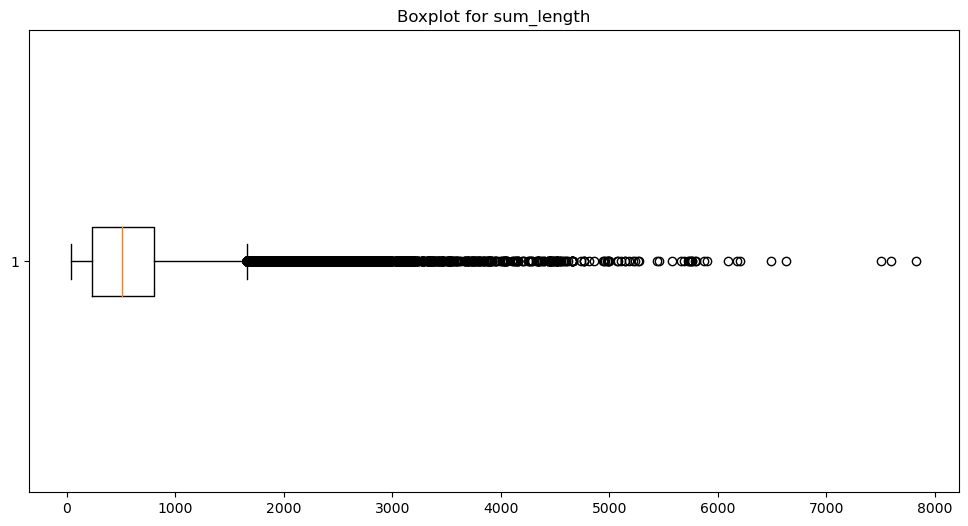

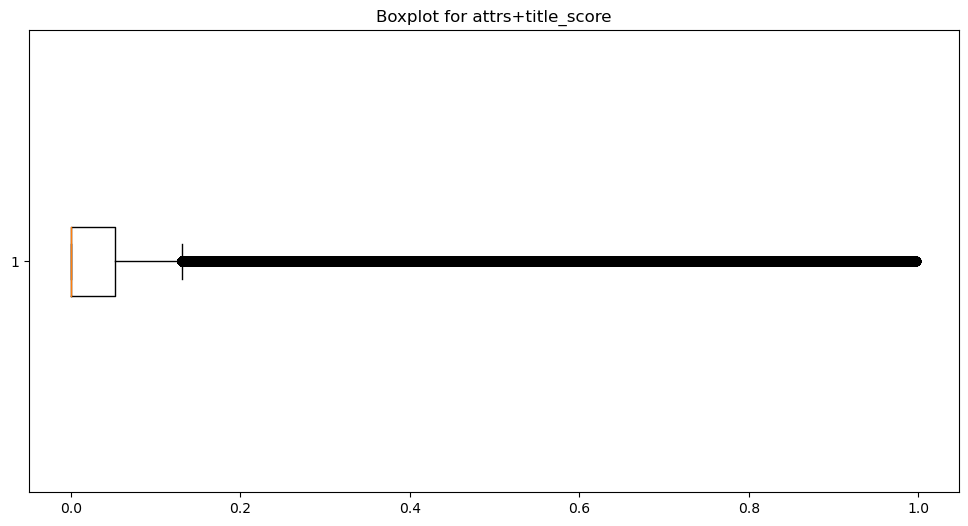

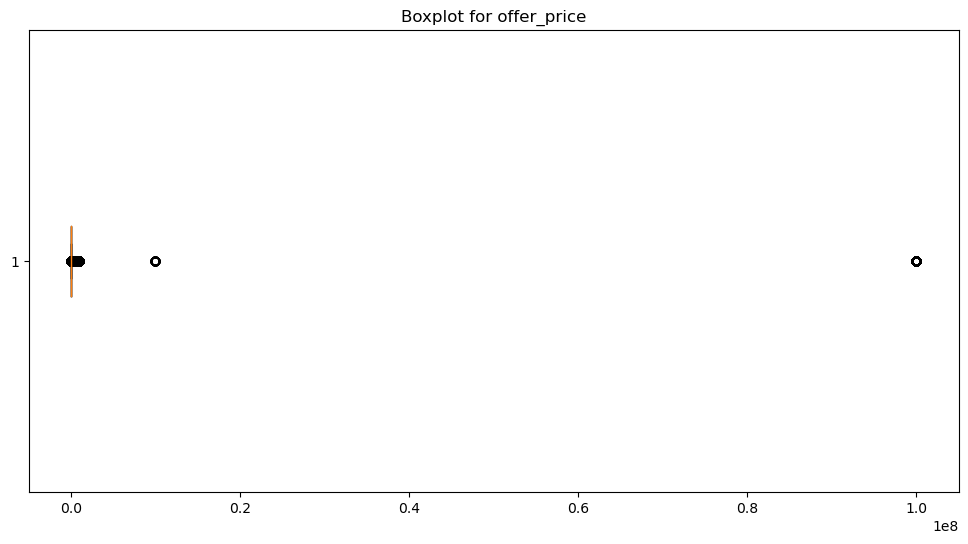

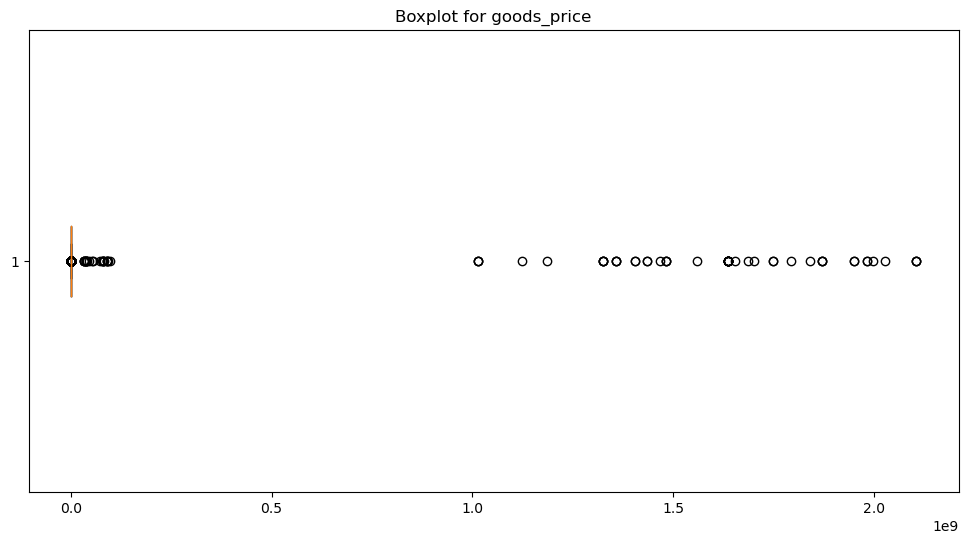

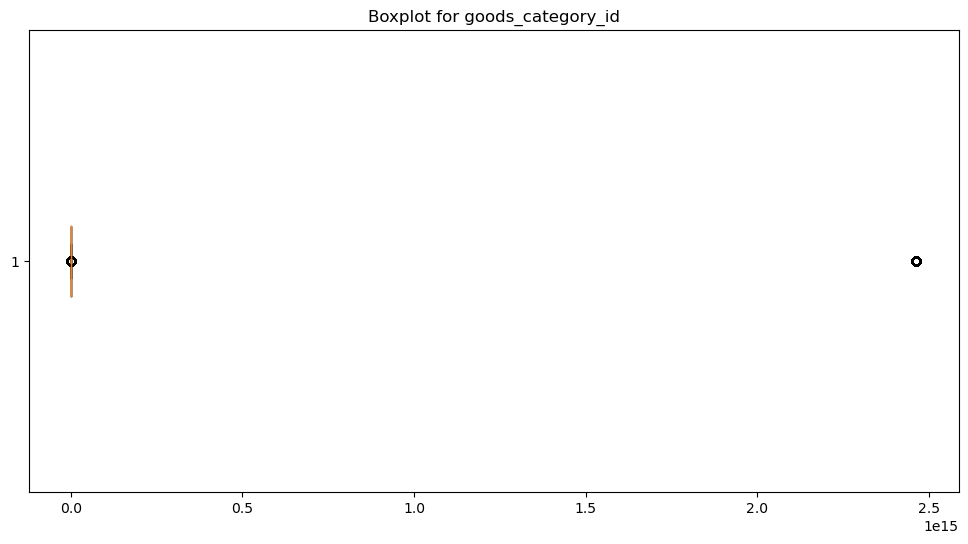

In [20]:
for column in columns:
    plt.figure(figsize=(12, 6))
    plt.boxplot(df[column].dropna(), vert=False)
    plt.title(f'Boxplot for {column}')

Мы видим немного выбросов. Избавимся от них.

In [21]:
df = df[~(df['sum_length']>5000)]

df = df[~(df['offer_price']>7*10**5)]

df = df[~(df['goods_price']>5*10**5)]

df = df[~(df['goods_category_id']>50)]

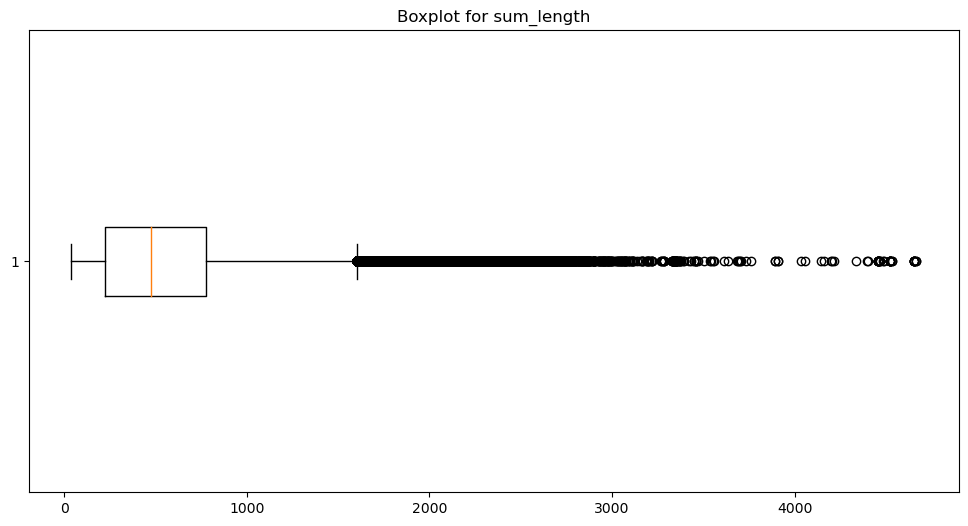

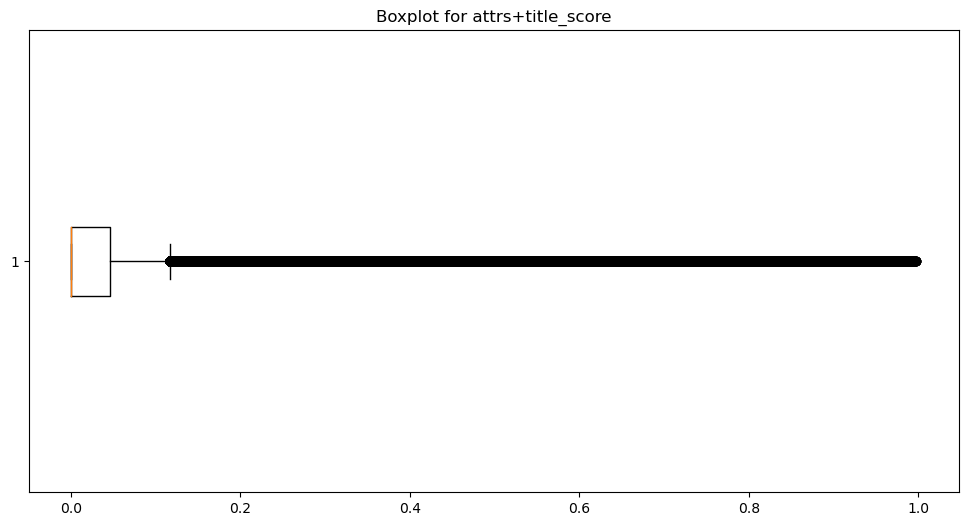

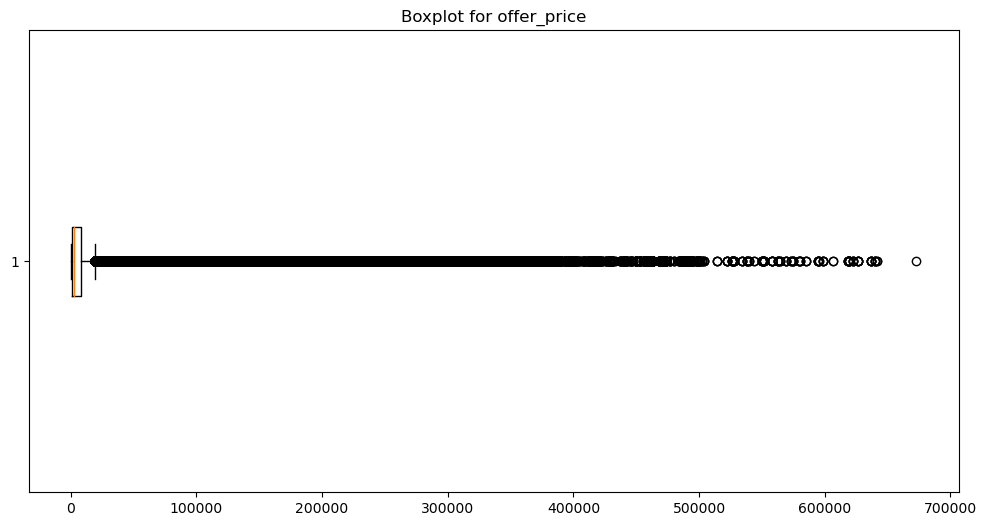

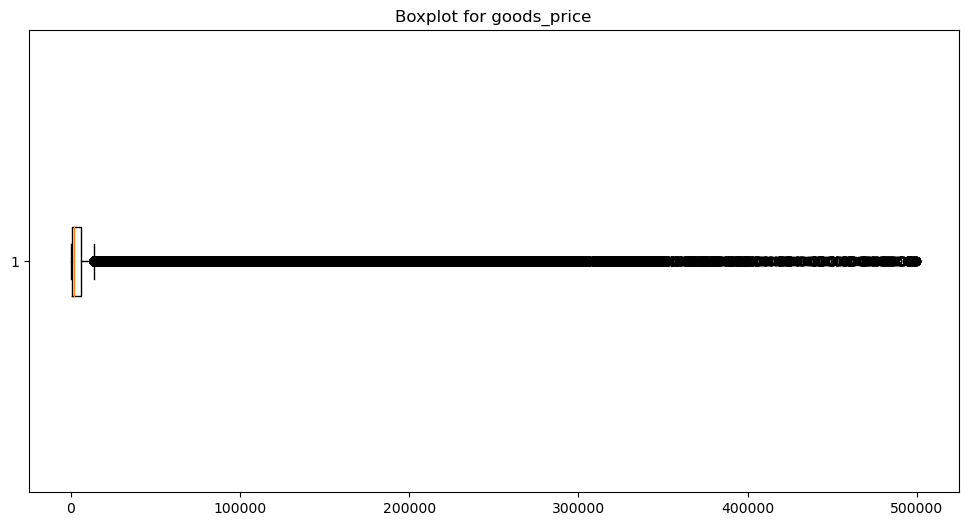

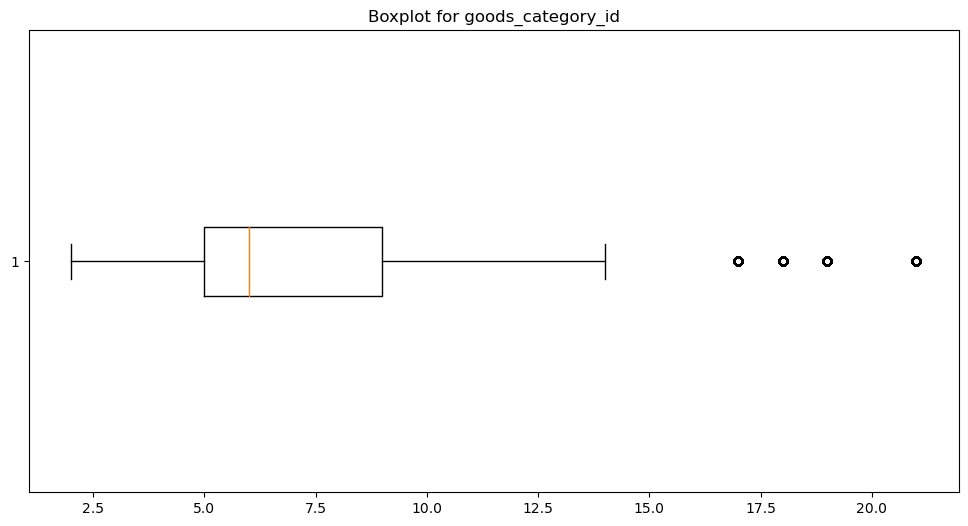

In [22]:
for column in columns:
    plt.figure(figsize=(12, 6))
    plt.boxplot(df[column].dropna(), vert=False)
    plt.title(f'Boxplot for {column}')

Выбросов стало меньше.

Построим столбчатую диаграмму для категорий товаров.

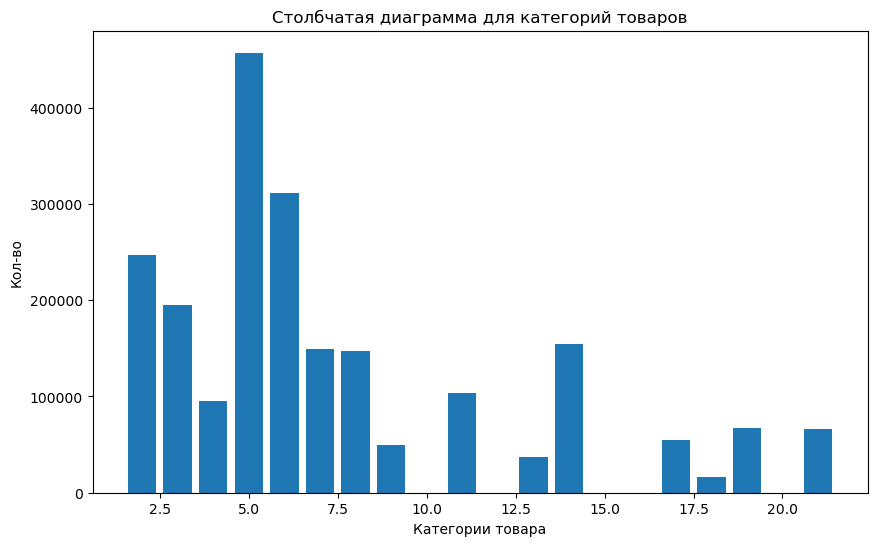

In [23]:
counts = df['goods_category_id'].value_counts()

plt.figure(figsize=(10, 6))

plt.bar(counts.index, counts.values)
plt.xlabel('Категории товара')
plt.ylabel('Кол-во')
plt.title('Столбчатая диаграмма для категорий товаров')

plt.show()

Мы видим, что у нас есть довольно большой разброс по категориям: больше всего товаров категории 5, а по некоторым категориям товаров совсем мало. Переведем тип данных этого столбца в категориальный, других изменений делать не будем.

## Работа с векторами

Откроем файлы с векторами, преобразуем их и затем объединим с основным набором данных.

In [24]:
goods_image_vectors = np.load('goods_image_vectors/goods_image_vectors/embed_deperson.npy')
goods_image_ids = np.load('goods_image_vectors/goods_image_vectors/items_deperson.npy')

offer_image_vectors = np.load('offer_image_vectors/offer_image_vectors/embed_deperson.npy')
offer_image_ids = np.load('offer_image_vectors/offer_image_vectors/items_deperson.npy')

goods_title_vectors = np.load('goods_title_vectors/goods_title_vectors/embed_deperson.npy')
goods_title_ids = np.load('goods_title_vectors/goods_title_vectors/items_deperson.npy')

offer_title_vectors = np.load('offer_title_vectors/offer_title_vectors/embed_deperson.npy')
offer_title_ids = np.load('offer_title_vectors/offer_title_vectors/items_deperson.npy')

In [25]:
display(goods_image_vectors.shape, goods_image_ids.shape, offer_image_vectors.shape, offer_image_ids.shape,
        goods_title_vectors.shape, goods_title_ids.shape, offer_title_vectors.shape, offer_title_ids.shape)

(317707, 256)

(317707,)

(457586, 256)

(457586,)

(1760568, 64)

(1760568,)

(572767, 64)

(572767,)

Преобразуем вектора в DataFrame:

In [26]:
goods_image_df = pd.DataFrame(goods_image_vectors, index=goods_image_ids)
offer_image_df = pd.DataFrame(offer_image_vectors, index=offer_image_ids)
goods_title_df = pd.DataFrame(goods_title_vectors, index=goods_title_ids)
offer_title_df = pd.DataFrame(offer_title_vectors, index=offer_title_ids)

In [27]:
display(goods_image_df.shape, offer_image_df.shape, goods_title_df.shape, offer_title_df.shape)

(317707, 256)

(457586, 256)

(1760568, 64)

(572767, 64)

Проверим их на дубликаты, и удалим их, если они присутствуют. Напишем функцию:

In [28]:
def remove_duplicates_by_index(df):
    df = df.reset_index().drop_duplicates(subset='index').set_index('index')
    return df

In [29]:
goods_image_df = remove_duplicates_by_index(goods_image_df)
offer_image_df = remove_duplicates_by_index(offer_image_df)
goods_title_df = remove_duplicates_by_index(goods_title_df)
offer_title_df = remove_duplicates_by_index(offer_title_df)

In [30]:
display(goods_image_df.shape, offer_image_df.shape, goods_title_df.shape, offer_title_df.shape)

(312554, 256)

(457585, 256)

(1760568, 64)

(572767, 64)

Начнем объединение данных. Сначала переведем индексы из датафреймов с векторами к типу int. Затем объединим все с основной таблицей.

In [31]:
goods_image_df.index = goods_image_df.index.astype(int)
offer_image_df.index = offer_image_df.index.astype(int)
goods_title_df.index = goods_title_df.index.astype(int)
offer_title_df.index = offer_title_df.index.astype(int)

In [32]:
df = df.merge(goods_image_df, left_on='goods_depersanalised', right_index=True, how='left')
df = df.merge(offer_image_df, left_on='offer_depersanalised', right_index=True, how='left',
              suffixes=('_goods_image', '_offer_image'))

In [33]:
df = df.merge(goods_title_df, left_on='goods_depersanalised', right_index=True, how='left')
df = df.merge(offer_title_df, left_on='offer_depersanalised', right_index=True, how='left',
              suffixes=('_goods_title', '_offer_title'))

In [34]:
pd.set_option('display.max_columns', None)
df.head(10)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id,0_goods_image,1_goods_image,2_goods_image,3_goods_image,4_goods_image,5_goods_image,6_goods_image,7_goods_image,8_goods_image,9_goods_image,10_goods_image,11_goods_image,12_goods_image,13_goods_image,14_goods_image,15_goods_image,16_goods_image,17_goods_image,18_goods_image,19_goods_image,20_goods_image,21_goods_image,22_goods_image,23_goods_image,24_goods_image,25_goods_image,26_goods_image,27_goods_image,28_goods_image,29_goods_image,30_goods_image,31_goods_image,32_goods_image,33_goods_image,34_goods_image,35_goods_image,36_goods_image,37_goods_image,38_goods_image,39_goods_image,40_goods_image,41_goods_image,42_goods_image,43_goods_image,44_goods_image,45_goods_image,46_goods_image,47_goods_image,48_goods_image,49_goods_image,50_goods_image,51_goods_image,52_goods_image,53_goods_image,54_goods_image,55_goods_image,56_goods_image,57_goods_image,58_goods_image,59_goods_image,60_goods_image,61_goods_image,62_goods_image,63_goods_image,64_goods_image,65_goods_image,66_goods_image,67_goods_image,68_goods_image,69_goods_image,70_goods_image,71_goods_image,72_goods_image,73_goods_image,74_goods_image,75_goods_image,76_goods_image,77_goods_image,78_goods_image,79_goods_image,80_goods_image,81_goods_image,82_goods_image,83_goods_image,84_goods_image,85_goods_image,86_goods_image,87_goods_image,88_goods_image,89_goods_image,90_goods_image,91_goods_image,92_goods_image,93_goods_image,94_goods_image,95_goods_image,96_goods_image,97_goods_image,98_goods_image,99_goods_image,100_goods_image,101_goods_image,102_goods_image,103_goods_image,104_goods_image,105_goods_image,106_goods_image,107_goods_image,108_goods_image,109_goods_image,110_goods_image,111_goods_image,112_goods_image,113_goods_image,114_goods_image,115_goods_image,116_goods_image,117_goods_image,118_goods_image,119_goods_image,120_goods_image,121_goods_image,122_goods_image,123_goods_image,124_goods_image,125_goods_image,126_goods_image,127_goods_image,128_goods_image,129_goods_image,130_goods_image,131_goods_image,132_goods_image,133_goods_image,134_goods_image,135_goods_image,136_goods_image,137_goods_image,138_goods_image,139_goods_image,140_goods_image,141_goods_image,142_goods_image,143_goods_image,144_goods_image,145_goods_image,146_goods_image,147_goods_image,148_goods_image,149_goods_image,150_goods_image,151_goods_image,152_goods_image,153_goods_image,154_goods_image,155_goods_image,156_goods_image,157_goods_image,158_goods_image,159_goods_image,160_goods_image,161_goods_image,162_goods_image,163_goods_image,164_goods_image,165_goods_image,166_goods_image,167_goods_image,168_goods_image,169_goods_image,170_goods_image,171_goods_image,172_goods_image,173_goods_image,174_goods_image,175_goods_image,176_goods_image,177_goods_image,178_goods_image,179_goods_image,180_goods_image,181_goods_image,182_goods_image,183_goods_image,184_goods_image,185_goods_image,186_goods_image,187_goods_image,188_goods_image,189_goods_image,190_goods_image,191_goods_image,192_goods_image,193_goods_image,194_goods_image,195_goods_image,196_goods_image,197_goods_image,198_goods_image,199_goods_image,200_goods_image,201_goods_image,202_goods_image,203_goods_image,204_goods_image,205_goods_image,206_goods_image,207_goods_image,208_goods_image,209_goods_image,210_goods_image,211_goods_image,212_goods_image,213_goods_image,214_goods_image,215_goods_image,216_goods_image,217_goods_image,218_goods_image,219_goods_image,220_goods_image,221_goods_image,222_goods_image,223_goods_image,224_goods_image,225_goods_image,226_goods_image,227_goods_image,228_goods_image,229_goods_image,230_goods_image,231_goods_image,232_goods_image,233_goods_image,234_goods_image,235_goods_image,236_goods_image,237_goods_image,238_goods_image,239_goods_image,240_goods_image,241_goods_image,242_goods_image,243_goods_image,244_goods_image,245_goods_image,246_goods_image,247_goods_image,248_goods_image,24

In [35]:
pd.set_option('display.max_info_columns', 10000)

df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2152470 entries, 0 to 2518393
Data columns (total 649 columns):
 #    Column                Non-Null Count    Dtype  
---   ------                --------------    -----  
 0    offer_depersanalised  2152470 non-null  int64  
 1    goods_depersanalised  2152470 non-null  int64  
 2    sum_length            2152470 non-null  int64  
 3    attrs+title_score     2152470 non-null  float64
 4    offer_price           2152470 non-null  int64  
 5    goods_price           1770039 non-null  float64
 6    goods_category_id     2152470 non-null  int64  
 7    target                2152470 non-null  int64  
 8    id                    2152470 non-null  object 
 9    0_goods_image         432178 non-null   float32
 10   1_goods_image         432178 non-null   float32
 11   2_goods_image         432178 non-null   float32
 12   3_goods_image         432178 non-null   float32
 13   4_goods_image         432178 non-null   float32
 14   5_goods_image        

К сожалению, у нас довольно много пропусков с векторами изображений для ассортимента (goods). Будем работать с тем, что имеем.

## Создание новых признаков

Создадим новый признак proceeds из двух признаков offer price и good price. Потом оба этих столбца опустим, оставив только новый признак.

In [36]:
df_modified = df.copy()

In [37]:
df_modified['proceeds'] = np.where(df_modified['goods_price'].isna(), np.nan,
                                   df_modified['goods_price'] - df_modified['offer_price'])

In [38]:
df_modified = df_modified.drop(['goods_price', 'offer_price'], axis=1)

In [39]:
df_modified.proceeds.info()

<class 'pandas.core.series.Series'>
Index: 2152470 entries, 0 to 2518393
Series name: proceeds
Non-Null Count    Dtype  
--------------    -----  
1770039 non-null  float64
dtypes: float64(1)
memory usage: 32.8 MB


## Важность и корреляция признаков

Изучим важность признаков и посмотрим на корреляцию признаков с таргетом и друг с другом.

### Корреляция признаков

Напишем функцию, которая будет удалять по одному признаку из каждой пары коррелирующих.

In [40]:
def remove_correlated_features(data, method='pearson', threshold=0.8):
    corr_matrix = data.corr(method=method).abs()
    
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]
    data.drop(to_drop, axis=1, inplace=True)
    
    return data

Применим ее к нашему датасету.

In [41]:
df_modified = df_modified.drop(['offer_depersanalised', 'goods_depersanalised', 'id'], axis=1)

In [42]:
# Для экономии времени помещяю исполнение кода под #
#df_modified = remove_correlated_features(df_modified)

In [43]:
#df_modified.info()

Мы видим, что корреляция между признаками отсутствует, т.к. ни один из признаков не был удален.

### Важность признаков

Перейдем к важности признаков. Для этого выделим отдельно таргет и признаки, обучим простую модель и посмотрим на важность признаков с помощью feature_importance.

In [44]:
df_modified['goods_category_id'] = df_modified['goods_category_id'].astype('category')

In [45]:
features_fi = df_modified.drop(['target'], axis=1)
target_fi = df_modified['target']

In [46]:
cat_list = ['goods_category_id']

In [47]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE, categorical_feature='name:cat_list', class_weight='balanced')
model_lgbm.fit(features_fi, target_fi)

[LightGBM] [Warning] categorical_feature is set=name:cat_list, categorical_column=2 will be ignored. Current value: categorical_feature=name:cat_list
[LightGBM] [Info] Number of positive: 239436, number of negative: 1913034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.411546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163980
[LightGBM] [Info] Number of data points in the train set: 2152470, number of used features: 644
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(categorical_feature='name:cat_list', class_weight='balanced',
               random_state=42)

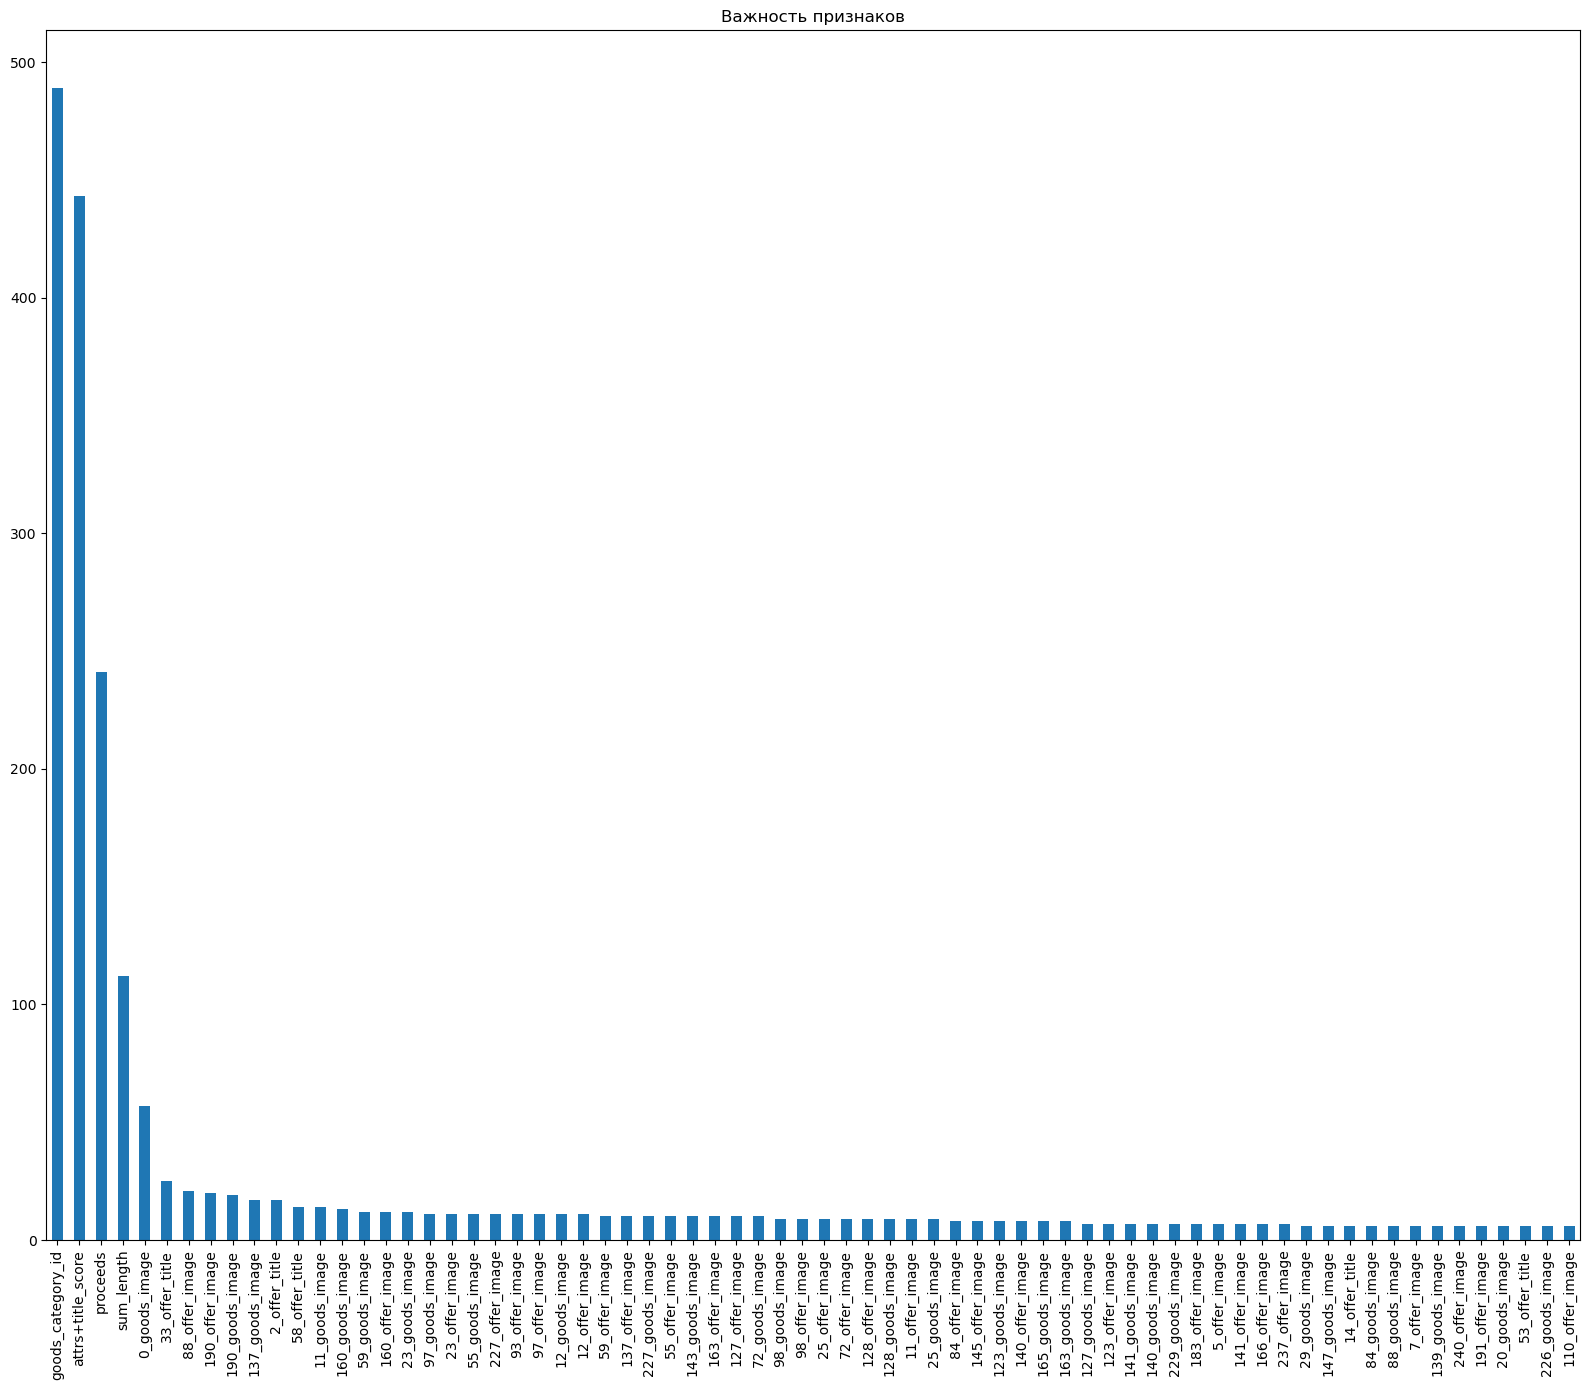

In [48]:
lgbm_imp = pd.Series(model_lgbm.feature_importances_, features_fi.columns)
fig, ax = plt.subplots(figsize=(16,14))
lgbm_imp.sort_values(ascending=False).head(70).plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

In [49]:
feature_importance = np.array(model_lgbm.feature_importances_)
feature_names = np.array(features_fi.columns)
data = {'feature_names':feature_names,'feature_importance':feature_importance}
fitures_df = pd.DataFrame(data=data)
fitures_df['feature_importance'] = fitures_df['feature_importance'].astype(np.int64)
fitures_df = fitures_df.sort_values(by=['feature_importance'], ascending=False).head(20)

In [50]:
pd.set_option('display.max_rows', None)
fitures_df

,feature_names,feature_importance
2,goods_category_id,489
1,attrs+title_score,443
643,proceeds,241
0,sum_length,112
3,0_goods_image,57
612,33_offer_title,25
347,88_offer_image,21
449,190_offer_image,20
193,190_goods_image,19
140,137_goods_image,17


Из наших 645 признаков я предлагаю отобрать топ-20 наиболее важных из них, остальные опустим.

In [51]:
columns_to_read = fitures_df['feature_names'].to_list() + ['target']

In [52]:
df_modified = df_modified.loc[:, columns_to_read]

In [53]:
df_modified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2152470 entries, 0 to 2518393
Data columns (total 21 columns):
 #   Column             Dtype   
---  ------             -----   
 0   goods_category_id  category
 1   attrs+title_score  float64 
 2   proceeds           float64 
 3   sum_length         int64   
 4   0_goods_image      float32 
 5   33_offer_title     float16 
 6   88_offer_image     float32 
 7   190_offer_image    float32 
 8   190_goods_image    float32 
 9   137_goods_image    float32 
 10  2_offer_title      float16 
 11  58_offer_title     float16 
 12  11_goods_image     float32 
 13  160_goods_image    float32 
 14  59_goods_image     float32 
 15  160_offer_image    float32 
 16  23_goods_image     float32 
 17  97_goods_image     float32 
 18  23_offer_image     float32 
 19  55_goods_image     float32 
 20  target             int64   
dtypes: category(1), float16(3), float32(13), float64(2), int64(2)
memory usage: 203.2 MB


## Обучение моделей

Перед обучением моделей выделим целевой признак и фичи. Затем выделим тестовый датасет размером 20% от исходной выборки.

In [54]:
features = df_modified.drop(['target'], axis=1)
target = df_modified['target']

In [55]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, stratify=target,
                                                                            random_state=RANDOM_STATE)

Снова посмотрим на дисбаланс классов:

In [56]:
target.value_counts()

target
0    1913034
1     239436
Name: count, dtype: int64

Проведем даунсемплинг перед обучением, используя функцию:

In [57]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)]
        + [features_ones])
    
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)]
        + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RANDOM_STATE)

    return features_downsampled, target_downsampled

In [58]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.14)

Обучим модель, проведем поиск лучших гиперпараметров через GreedsearchCV.

In [59]:
cat_list = ['goods_category_id']

In [60]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE, categorical_feature='name:cat_list', class_weight='balanced')
model_lgbm.fit(features_downsampled, target_downsampled)

[LightGBM] [Warning] categorical_feature is set=name:cat_list, categorical_column=0 will be ignored. Current value: categorical_feature=name:cat_list
[LightGBM] [Info] Number of positive: 191549, number of negative: 214260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4860
[LightGBM] [Info] Number of data points in the train set: 405809, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(categorical_feature='name:cat_list', class_weight='balanced',
               random_state=42)

In [61]:
scorer = make_scorer(f1_score)

In [62]:
parameters = {
     'num_iterations': [1000],
     'learning_rate':[0.01, 0.05],
     'num_leaves':[7, 15],
     'max_depth' :[8, 12],
}

In [63]:
%%time

grid_search = GridSearchCV(model_lgbm, parameters, cv=5, scoring=scorer, n_jobs=-1)

grid_search.fit(features_downsampled, target_downsampled)

print('Best parameters:', grid_search.best_params_)
print('Best parameters:', grid_search.best_score_)

[LightGBM] [Warning] categorical_feature is set=name:cat_list, categorical_column=0 will be ignored. Current value: categorical_feature=name:cat_list
[LightGBM] [Info] Number of positive: 191549, number of negative: 214260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4860
[LightGBM] [Info] Number of data points in the train set: 405809, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best parameters: {'learning_rate': 0.05, 'max_depth': 8, 'num_iterations': 1000, 'num_leaves': 15}
Best parameters: 0.9808983621025013
CPU times: total: 1min 3s
Wall time: 5min


Проверим модель с лучшими гиперпараметрами на тестовых данных:

In [64]:
model_lgbm = LGBMClassifier(
    random_state=RANDOM_STATE,
    categorical_feature='name:cat_list',
    class_weight='balanced',
    learning_rate=0.05,
    max_depth=8,
    num_iterations=1000,
    num_leaves=15,
)
model_lgbm.fit(features_train, target_train)
predictions = model_lgbm.predict(features_test)
f1_score = f1_score(target_test, predictions)
print("F1 score на тестовых данных:", f1_score)

[LightGBM] [Warning] categorical_feature is set=name:cat_list, categorical_column=0 will be ignored. Current value: categorical_feature=name:cat_list
[LightGBM] [Info] Number of positive: 191549, number of negative: 1530427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4860
[LightGBM] [Info] Number of data points in the train set: 1721976, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
F1 score на тестовых данных: 0.9060945451767829


## Работа с тестовым датасетом

Откроем наш тестовый датасет и проведем ту же предобработку, что мы делали ранее.

In [65]:
df_test = pd.read_csv('test.csv')

In [66]:
df_test.head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
0,64819,1396468,38,0.046997,368,NaN,14.0,64819$1396468
1,64819,1396235,38,0.046997,368,NaN,14.0,64819$1396235
2,64819,1396318,38,0.046997,368,NaN,14.0,64819$1396318
3,359959,1396281,40,0.060211,634,NaN,14.0,359959$1396281
4,142700,717657,40,0.000370,14924,31840.0,2.0,142700$717657


In [67]:
df_test.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   offer_depersanalised  363835 non-null  int64  
 1   goods_depersanalised  363835 non-null  int64  
 2   sum_length            363835 non-null  int64  
 3   attrs+title_score     363835 non-null  float64
 4   offer_price           363835 non-null  int64  
 5   goods_price           304864 non-null  float64
 6   goods_category_id     363704 non-null  float64
 7   id                    363835 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 22.2+ MB


In [68]:
df_test['goods_category_id'] = df_test['goods_category_id'].astype('category')

In [69]:
df_test.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   offer_depersanalised  363835 non-null  int64   
 1   goods_depersanalised  363835 non-null  int64   
 2   sum_length            363835 non-null  int64   
 3   attrs+title_score     363835 non-null  float64 
 4   offer_price           363835 non-null  int64   
 5   goods_price           304864 non-null  float64 
 6   goods_category_id     363704 non-null  category
 7   id                    363835 non-null  object  
dtypes: category(1), float64(2), int64(4), object(1)
memory usage: 19.8+ MB


In [70]:
duplicates = df_test[df_test['id'].duplicated()].shape[0]
duplicates

0

In [71]:
df_test['proceeds'] = np.where(df_test['goods_price'].isna(), np.nan,
                                   df_test['goods_price'] - df_test['offer_price'])
df_test = df_test.drop(['goods_price', 'offer_price'], axis=1)

In [72]:
df_test = df_test.merge(goods_image_df, left_on='goods_depersanalised', right_index=True, how='left')
df_test = df_test.merge(offer_image_df, left_on='offer_depersanalised', right_index=True, how='left',
                        suffixes=('_goods_image', '_offer_image'))

In [73]:
df_test = df_test.merge(goods_title_df, left_on='goods_depersanalised', right_index=True, how='left')
df_test = df_test.merge(offer_title_df, left_on='offer_depersanalised', right_index=True, how='left',
              suffixes=('_goods_title', '_offer_title'))

Выберем только те 15 признаков, на которых мы обучали модель.

In [74]:
columns_to_read_test = fitures_df['feature_names'].to_list()

In [75]:
features = df_test.copy()

In [76]:
features = features.loc[:, columns_to_read_test]

In [77]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   goods_category_id  363704 non-null  category
 1   attrs+title_score  363835 non-null  float64 
 2   proceeds           304864 non-null  float64 
 3   sum_length         363835 non-null  int64   
 4   0_goods_image      78374 non-null   float32 
 5   33_offer_title     363835 non-null  float16 
 6   88_offer_image     291255 non-null  float32 
 7   190_offer_image    291255 non-null  float32 
 8   190_goods_image    78374 non-null   float32 
 9   137_goods_image    78374 non-null   float32 
 10  2_offer_title      363835 non-null  float16 
 11  58_offer_title     363835 non-null  float16 
 12  11_goods_image     78374 non-null   float32 
 13  160_goods_image    78374 non-null   float32 
 14  59_goods_image     78374 non-null   float32 
 15  160_offer_image    291255 non-null

In [78]:
target_test = model_lgbm.predict(features)

In [79]:
target_test = pd.DataFrame(target_test)

In [80]:
target_test.columns = ['target']

In [81]:
target_test['id'] = df_test['id']

In [82]:
target_test = target_test[['id', 'target']]

In [83]:
target_test.head(10)

,id,target
0,64819$1396468,0
1,64819$1396235,0
2,64819$1396318,0
3,359959$1396281,0
4,142700$717657,0
5,142713$717657,0
6,230214$717657,0
7,106880$1396551,0
8,460062$1396292,0
9,142719$717657,0


In [84]:
target_test.to_csv("target_test.csv", index=False)

## Выводы

Итак, в ходе проделанной работы мы:
1. Изучили наши данные и провели предобработку:
- Удалили пропуски в столбце *goods_category_id*;
- удалили дубликаты в столбце *id*, а также дубликаты в эмбендингах;
- избвились от аномалий;
- привели столбцы к нужному типу.
2. Объединили основной датасет с векторами изображений и текста.
3. Создали новый признак *proceeds* из двух признаков *offer price* и *good price*.
4. Проверили признаки на корреляцию и выбрали топ-20 самых важных признаков с помощью feature_importances_.
5. Выделили тестовый датасет размером 20% от исходной выборки. Затем провели даунсемплинг и обучили модель градиентного бустинга LightGBM.
6. Подобрали лучшие гиперпараметры для нашей модели с помощью GridsearchCV, проверили лучшую модель на тестовых данных, получили результат f1_score = 0.90609.
7. Обучили нашу лучшую модель на тестовом датасете, загрузили файл с предсказаниями на kaggle, получили результат f1_score = 0.89827 на публичном наборе данных.